In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from rvdata.core.models.level2 import RV2


#To download the input files for this example, set download=1 to run the code block below
download=0

if download == 1:
    import requests

    def download_file(url, filename):
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful
        with open(filename, "wb") as file:
            file.write(response.content)

    #Download the native, input FITS files for this example if not already on your computer
    file_urls = {
        "KPF": [
            "https://zenodo.org/records/15021737/files/KP.20250208.17485.59.fits?download=1",
            "https://zenodo.org/records/15021737/files/KP.20250208.17485.59_L1.fits?download=1",
        ]
    }


## Using the L2 translator to go from native data format to the EPRV Standard Format

In [ ]:
#Translating a KPF File [change file destination to where you have placed the L0 and L1 KPF files from Zenodo]
l1file = '/Users/jenburt/Desktop/EPRV_Standard/KP.20250208.17485.59_L1.fits'
l0file = '/Users/jenburt/Desktop/EPRV_Standard/KP.20250208.17485.59.fits'

with fits.open(l1file) as hdul:
        datetime = hdul[0].header['DATE-BEG']
        timestamp, seconds = datetime.split('.')

filetime = timestamp.replace(":","").replace("-","")
kpf_l2_filename = './docs/tutorials/KPFL2_'+filetime.replace("-:","")+'.fits'

kpf_l2 = RV2.from_fits(l1file, l0file=l0file, instrument="KPF")
kpf_l2.to_fits(kpf_l2_filename)

./KPFL2_20250208T045125.fits


## Examining What's Inside the Community Standard L2 File

You can access the l2 file either as a traditional FITS object using astropy's fits.open() function, or as a python object using the from_fits() function within RV2. In this example we'll use the astropy fits.open() approach.

In [56]:
#Read in the community standard L2 FITS file created above
#l2 = fits.open(kpf_l2_filename)

#The primary header contains useful info about what was observed, what's in each trace, etc. The keywords will be the same regardless
#of what facility was used to take the data, so you can always query the file in the same way.
#primary_header = l2[0].header
print('What telescope produced this observation?  ',primary_header['TELESCOP'])
print('What instrument was used?  ',primary_header['INSTRUME'])
print('What object was observed?  ',primary_header['OBJECT'],)
print('How many traces are produced by the spectrograph?  ',primary_header['NUMTRACE'] )
print('What is in each of the traces? ')
for i in range(1,int(primary_header['NUMTRACE'])+1):
    print('Trace',i,primary_header['TRACE'+str(i)])

#Print the Extension Description Table to see what is stored in each FITS extension
#hdul[4].data



What telescope produced this observation?   Keck I
What instrument was used?   KPF
What object was observed?   10700
How many traces are produced by the spectrograph?   5
What is in each of the traces? 
Trace 1 EtalonFiber
Trace 2 Target
Trace 3 Target
Trace 4 Target
Trace 5 Sky


### The Extension Description table, located in Extension #4 "EXT_DESCRIPT" lists all of the FITS extensions in the L2 file

In [ ]:
print(l2[4].data)

[]


### And the Order Table, located in Extension #5 "ORDER_TABLE" details the start and end wavelengths of each echelle order

In [58]:
print(l2[5].data)

[]


## Plotting Examples of L2 Spectra

From the Extension Description table, we know that the stellar data is contained in Traces 2, 3, and 4 -- so we can take a look at those

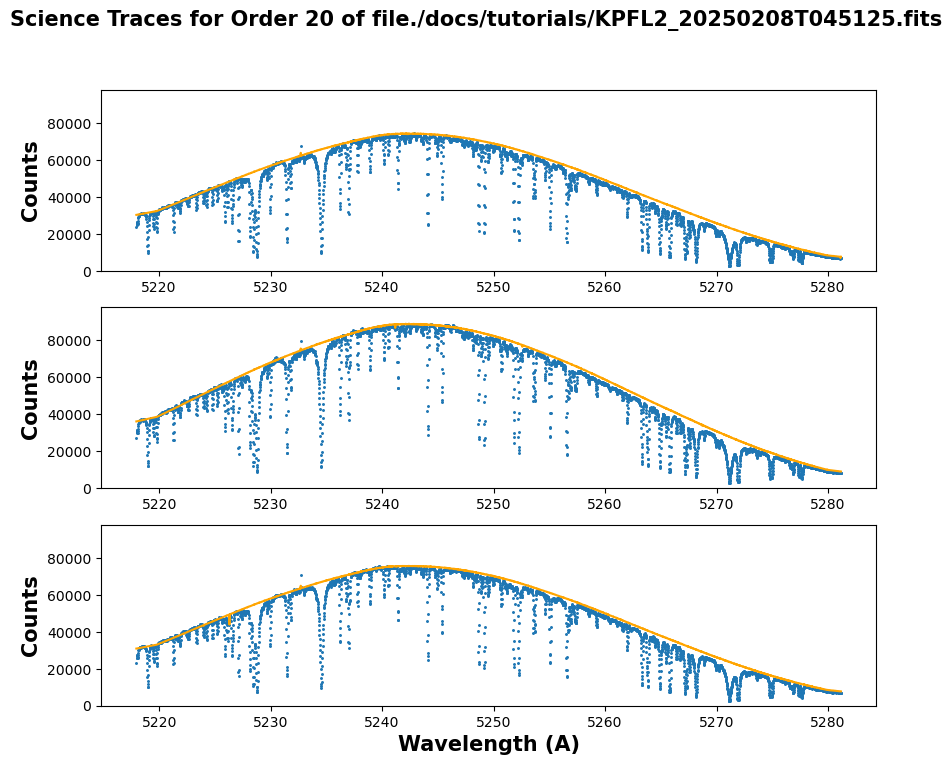

In [ ]:
#specify what order you'd like to plot
order = 20

#standardize the y-axis range based on the order with this highest flux measurements so it's easier to compare
flux_max = np.max([np.max(l2['TRACE2_FLUX'].data[order]), np.max(l2['TRACE3_FLUX'].data[order]), np.max(l2['TRACE4_FLUX'].data[order])])
ymax = flux_max*1.1

#Calculate scaling factors between the blaze extensions and the flux extensions for easier visual comparison
blz_scale2 = np.nanmax(l2['TRACE2_FLUX'].data[order]/np.nanmax(l2['TRACE2_BLAZE'].data[order]))
blz_scale3 = np.nanmax(l2['TRACE3_FLUX'].data[order]/np.nanmax(l2['TRACE3_BLAZE'].data[order]))
blz_scale4 = np.nanmax(l2['TRACE4_FLUX'].data[order]/np.nanmax(l2['TRACE4_BLAZE'].data[order]))

fig = plt.figure(1,[10,8])

ax1 = fig.add_subplot(3,1,1)
ax1.scatter(l2['TRACE2_WAVE'].data[order],l2['TRACE2_FLUX'].data[order],marker='.',s=5)
ax1.plot(l2['TRACE2_WAVE'].data[order],l2['TRACE2_BLAZE'].data[order]*blz_scale2,color='orange')
ax1.set_ylim(0,ymax)
ax1.set_ylabel('Counts',fontsize=15,fontweight='bold')

ax2 = fig.add_subplot(3,1,2)
ax2.scatter(l2['TRACE3_WAVE'].data[order],l2['TRACE3_FLUX'].data[order],marker='.',s=5)
ax2.plot(l2['TRACE3_WAVE'].data[order],l2['TRACE3_BLAZE'].data[order]*blz_scale3,color='orange')
ax2.set_ylim(0,ymax)
ax2.set_ylabel('Counts',fontsize=15,fontweight='bold')

ax3 = fig.add_subplot(3,1,3)
ax3.scatter(l2['TRACE4_WAVE'].data[order],l2['TRACE4_FLUX'].data[order],marker='.',s=5)
ax3.plot(l2['TRACE4_WAVE'].data[order],l2['TRACE4_BLAZE'].data[order]*blz_scale4,color='orange')
ax3.set_ylim(0,ymax)
ax3.set_ylabel('Counts',fontsize=15,fontweight='bold')
ax3.set_xlabel('Wavelength (A)',fontsize=15,fontweight='bold')

fig.suptitle('Science Traces for Order '+str(order)+' of file'+kpf_l2_filename,fontsize=15,fontweight='bold')

plt.show()

## L2 --> L3 Data Stitching Example & Plots

## L2 --> L4 translation

## Reading in L4 files for a few observations from multiple instruments and plotting those